# Golf Model

In [171]:
# File and path manipulation
import joblib
import os, shutil
import json
from tensorflow.keras.models import load_model
from joblib import load
from joblib import dump
from IPython.display import FileLinks
from xgboost import Booster
import booster

# Scraping
import requests
import csv
from datetime import datetime
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D

import warnings
warnings.filterwarnings('ignore') # Ignores warning messages

In [85]:
from config import api_key

api_key = api_key

In [86]:
ids_url = f'https://feeds.datagolf.com/historical-raw-data/event-list?file_format=json&key={api_key}'

In [91]:
response = requests.get(ids_url)
if response.status_code == 200:
    # Parse the JSON response
    event_list = response.json()
    # Assuming the JSON structure is a list of events
    for event in event_list:
        print(f"Event Name: {event['event_name']} - Event ID: {event['event_id']}")
else:
    print(f"Error fetching event list: {response.status_code}")

Event Name: Valero Texas Open - Event ID: 41
Event Name: Miami - Event ID: 28
Event Name: Club Car Championship at The Landings Golf & Athletic Club - Event ID: 128
Event Name: Singha Championship - Event ID: 10333
Event Name: Limpopo Championship - Event ID: 10332
Event Name: Nissan presents Chandigarh Open 2024 hosted by Chandigarh Golf Club - Event ID: 10331
Event Name: Villa Rica Classic - Event ID: 10334
Event Name: Novil Cup - Event ID: 10330
Event Name: Texas Children's Houston Open - Event ID: 20
Event Name: Totalplay Championship at Atlas Country Club - Event ID: 17
Event Name: The Galleri Classic - Event ID: 56
Event Name: Hero Indian Open - Event ID: 2024114
Event Name: Token Homemate Cup - Event ID: 10327
Event Name: Porsche Singapore Classic - Event ID: 2024113
Event Name: Kolkata Challenge - Event ID: 2024308
Event Name: Bupa Championship at Tulum - Event ID: 1
Event Name: Valspar Championship - Event ID: 475
Event Name: Hoag Classic - Event ID: 573
Event Name: Stella Art

In [92]:
events_df = pd.DataFrame(event_list)

In [93]:
events_df

calendar_year        date  event_id  \
0              2024  2024-04-07        41   
1              2024  2024-04-07        28   
2              2024  2024-04-07       128   
3              2024  2024-04-07     10333   
4              2024  2024-04-07     10332   
...             ...         ...       ...   
1894           2017  2017-01-22   2017004   
1895           2017  2017-01-15         6   
1896           2017  2017-01-15   2017002   
1897           2017  2017-01-11       124   
1898           2017  2017-01-08        16   

                                             event_name sg_categories  tour  \
0                                     Valero Texas Open           yes   pga   
1                                                 Miami            no   liv   
2     Club Car Championship at The Landings Golf & A...            no   kft   
3                                   Singha Championship            no  atgt   
4                                  Limpopo Championship            no   afr   
...                                                 ...           ...   ...   
1894                        Abu Dhabi HSBC Championship            no  euro   
1895                                Sony Open in Hawaii           yes   pga   
1896           BMW SA Open hosted by City of Ekurhuleni            no  euro   
1897  The Bahamas Great Exuma Classic at Sandals Eme...            no   kft   
1898                        SBS Tournament of Champions           yes   pga   

     traditional_stats  
0                  yes  
1                basic  
2                   no  
3                   no  
4                   no  
...                ...  
1894                no  
1895               yes  
1896                no  
1897                no  
1898               yes  

[1899 rows x 7 columns]

In [94]:
majors = ['The Masters', 'U.S. Open', 'The Open Championship', 'PGA Championship']

# Filter the DataFrame for the major tournaments
majors_df = events_df[events_df['event_name'].isin(majors)]

# Reset index after filtering
majors_df = majors_df.reset_index(drop=True)

# Display the DataFrame
majors_df.head()

# If you need the event_id as a dictionary:
major_event_ids = dict(zip(majors_df['event_name'], majors_df['event_id']))
print(major_event_ids)

{'PGA Championship': 33, 'The Open Championship': 100, 'U.S. Open': 26, 'The Masters': 14}


In [95]:
majors_df.head()

calendar_year        date  event_id             event_name sg_categories  \
0           2023  2023-09-23     10153       PGA Championship            no   
1           2023  2023-07-23       100  The Open Championship           yes   
2           2023  2023-06-18        26              U.S. Open           yes   
3           2023  2023-05-21        33       PGA Championship           yes   
4           2022  2022-11-06      9788       PGA Championship            no   

  tour traditional_stats  
0  afr                no  
1  pga               yes  
2  pga               yes  
3  pga               yes  
4  afr                no

In [96]:
base_url = url = f'https://feeds.datagolf.com/historical-raw-data/rounds?tour=pga&event_id=535&year=2021&file_format=json&key={api_key}'

def get_golf_stats(tour, event_id, year, api_key):
    params = {
        'tour': tour,
        'event_id': event_id,
        'year': year,
        'file_format': 'json',
        'key': api_key
    }
    response = requests.get(base_url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

# Define years of interest
years_of_interest = range(2019, datetime.now().year + 1)

# Specify the event_id for the U.S. Open
event_ids = {'U.S. Open': '535'} 

In [97]:
filename = 'full_golf_data.csv'

# Open the file and write the CSV data
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Year', 'Event ID', 'Event Name', 'Player Name', 'Round', 'Score', 'SG Total', 'Driving Distance', 'GIR', 'Scrambling'])
    
    for year in years_of_interest:
        for event_name, event_id in event_ids.items():
            # Get the stats for event
            stats = get_golf_stats('pga', event_id, year, api_key)
            
            # Check if stats is not None
            if stats:
                # Process and write data to CSV
                for player in stats['scores']:
                    for round_number, round_data in player.items():
                        if round_number.startswith('round_'):
                            writer.writerow([
                                year,
                                event_id,
                                event_name,
                                player['player_name'],
                                round_number[-1],
                                round_data['score'],
                                round_data['sg_total'],
                                round_data['driving_dist'],
                                round_data['gir'],
                                round_data['scrambling']
                            ])

print("Data collection complete. CSV file created.")

Data collection complete. CSV file created.


In [98]:
# Specify the path to the CSV file
golf_data_df = pd.read_csv(filename)

# Now you can display the first few rows of the DataFrame to check it
df = golf_data_df
df

Year  Event ID Event Name        Player Name  Round  Score  SG Total  \
0     2019       535  U.S. Open          Rahm, Jon      1     69     4.718   
1     2019       535  U.S. Open          Rahm, Jon      2     70     3.787   
2     2019       535  U.S. Open          Rahm, Jon      3     72     0.408   
3     2019       535  U.S. Open          Rahm, Jon      4     67     6.169   
4     2019       535  U.S. Open  Oosthuizen, Louis      1     67     6.718   
...    ...       ...        ...                ...    ...    ...       ...   
2713  2024       535  U.S. Open       Furr, Wilson      1     77    -3.282   
2714  2024       535  U.S. Open       Furr, Wilson      2     82    -8.213   
2715  2024       535  U.S. Open      Hervol, James      1     79    -5.282   
2716  2024       535  U.S. Open      Hervol, James      2     81    -7.213   
2717  2024       535  U.S. Open    Hovland, Viktor      1     74    -0.282   

      Driving Distance    GIR  Scrambling  
0                311.5  0.556       0.778  
1                315.7  0.611       0.667  
2                316.8  0.778       0.500  
3                323.1  0.778       0.800  
4                301.6  0.667       0.833  
...                ...    ...         ...  
2713             304.3  0.278       0.583  
2714             301.9  0.500       0.200  
2715             305.8  0.222       0.529  
2716             306.4  0.500       0.182  
2717             304.9  0.500       0.545  

[2718 rows x 10 columns]

In [99]:
event_list_url = "https://feeds.datagolf.com/historical-raw-data/event-list"
data_base_url = "https://feeds.datagolf.com/historical-raw-data/rounds"

# Define the years of interest
years_of_interest = range(2019, datetime.now().year + 1)

# The names of the major tournaments
majors_names = ['The Masters', 'U.S. Open', 'The Open Championship', 'PGA Championship']

# Fetch the event IDs for each major tournament
majors_event_ids = {year: {major: None for major in majors_names} for year in years_of_interest}

for year in years_of_interest:
    # Make the request for each year
    response = requests.get(f"{event_list_url}?file_format=json&key={api_key}")
    if response.status_code == 200:
        events = response.json()
        # Find the event IDs for the majors
        for event in events:
            if event['event_name'] in majors_names:
                majors_event_ids[year][event['event_name']] = event['event_id']
    else:
        print(f"Failed to fetch events for {year}: {response.status_code}")

# Now that we have the event IDs, we can fetch the round data for each major
all_majors_data = []

for year, events in majors_event_ids.items():
    for major, event_id in events.items():
        if event_id:  # If an event ID was found
            response = requests.get(f"{data_base_url}?tour=pga&event_id={event_id}&year={year}&file_format=json&key={api_key}")
            if response.status_code == 200:
                data = response.json()
                # Add additional info
                for record in data['scores']:
                    record['event_name'] = major
                    record['year'] = year
                all_majors_data.extend(data['scores'])
            else:
                print(f"Failed to fetch data for {major} ({year}): {response.status_code}")

# Convert all the collected data into a DataFrame
df_majors = pd.DataFrame(all_majors_data)

# Save the DataFrame to a CSV file
df_majors.to_csv('all_majors_data.csv', index=False)

# Show the DataFrame
print(df_majors.head())

Failed to fetch data for The Open Championship (2020): 400
Failed to fetch data for The Masters (2021): 400
Failed to fetch data for U.S. Open (2021): 400
Failed to fetch data for The Masters (2024): 400
Failed to fetch data for U.S. Open (2024): 400
Failed to fetch data for The Open Championship (2024): 400
Failed to fetch data for PGA Championship (2024): 400
   dg_id fin_text          player_name  \
0   5321        1         Woods, Tiger   
1  12422       T2      Johnson, Dustin   
2  16243       T2       Koepka, Brooks   
3  19895       T2   Schauffele, Xander   
4   7655       T5  Molinari, Francesco   

                                             round_1  \
0  {'course_name': 'Augusta National GC', 'course...   
1  {'course_name': 'Augusta National GC', 'course...   
2  {'course_name': 'Augusta National GC', 'course...   
3  {'course_name': 'Augusta National GC', 'course...   
4  {'course_name': 'Augusta National GC', 'course...   

                                             r

In [100]:
event_list_url = "https://feeds.datagolf.com/historical-raw-data/event-list"
data_base_url = "https://feeds.datagolf.com/historical-raw-data/rounds"

# Define the years of interest
years_of_interest = range(2019, datetime.now().year + 1)

# The names of the major tournaments
majors_names = ['The Masters', 'U.S. Open', 'The Open Championship', 'PGA Championship']

# Fetch the event IDs for each major tournament
majors_event_ids = {year: {major: None for major in majors_names} for year in years_of_interest}

for year in years_of_interest:
    for event_name, event_id in majors_event_ids[year].items():  # Use the event IDs for each major
        # Get the stats for the event
        stats = get_golf_stats('pga', event_id, year, api_key)
        # ... (rest of your stats collection and CSV writing code)
        
filename = 'full_golf_data.csv'

# Open the file and write the CSV data
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Year', 'Event ID', 'Event Name', 'Player Name', 'Round', 'Score', 'SG Total', 'Driving Distance', 'GIR', 'Scrambling'])
    
    for year in years_of_interest:
        for event_name, event_id in event_ids.items():
            # Get the stats for event
            stats = get_golf_stats('pga', event_id, year, api_key)
            
            # Check if stats is not None
            if stats:
                # Process and write data to CSV
                for player in stats['scores']:
                    for round_number, round_data in player.items():
                        if round_number.startswith('round_'):
                            writer.writerow([
                                year,
                                event_id,
                                event_name,
                                player['player_name'],
                                round_number[-1],
                                round_data['score'],
                                round_data['sg_total'],
                                round_data['driving_dist'],
                                round_data['gir'],
                                round_data['scrambling']
                            ])

print("Data collection complete. CSV file created.")

Data collection complete. CSV file created.


In [104]:
pd.read_csv('full_golf_data.csv')

Year  Event ID        Event Name        Player Name  Round  Score  \
0      2019       NaN       The Masters          Rahm, Jon      1     69   
1      2019       NaN       The Masters          Rahm, Jon      2     70   
2      2019       NaN       The Masters          Rahm, Jon      3     72   
3      2019       NaN       The Masters          Rahm, Jon      4     67   
4      2019       NaN       The Masters  Oosthuizen, Louis      1     67   
...     ...       ...               ...                ...    ...    ...   
10867  2024       NaN  PGA Championship       Furr, Wilson      1     77   
10868  2024       NaN  PGA Championship       Furr, Wilson      2     82   
10869  2024       NaN  PGA Championship      Hervol, James      1     79   
10870  2024       NaN  PGA Championship      Hervol, James      2     81   
10871  2024       NaN  PGA Championship    Hovland, Viktor      1     74   

       SG Total  Driving Distance    GIR  Scrambling  
0         4.718             311.5  0.556       0.778  
1         3.787             315.7  0.611       0.667  
2         0.408             316.8  0.778       0.500  
3         6.169             323.1  0.778       0.800  
4         6.718             301.6  0.667       0.833  
...         ...               ...    ...         ...  
10867    -3.282             304.3  0.278       0.583  
10868    -8.213             301.9  0.500       0.200  
10869    -5.282             305.8  0.222       0.529  
10870    -7.213             306.4  0.500       0.182  
10871    -0.282             304.9  0.500       0.545  

[10872 rows x 10 columns]

Data collection complete. CSV file created.


# EDA/Modeling

In [119]:
years_of_interest = range(2019, datetime.now().year + 1)

event_ids_for_majors = {
    'The Masters': '14',
    'U.S. Open': '26',
    'The Open Championship': '100',
    'PGA Championship': '33'
}

# Create a dictionary with years as keys and the event IDs dictionary as values
majors_event_ids = {year: event_ids_for_majors for year in years_of_interest}




new_filename = 'test_majors_data.csv'

# Open the file and write the CSV data
with open(new_filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Year', 'Event ID', 'Event Name', 'Player Name', 'Round', 'Score', 'SG Total', 'Driving Distance', 'Driving Accuracy', 
                     'GIR', 'Scrambling', 'Fairway Proximity', 'Rough Proximity', 'Great Shots', 'Poor Shots', 'Tee Time', 'Final Position'])
    
    for year in years_of_interest:
        for event_name, event_id in majors_event_ids[year].items():  # Use the event IDs for each major
            # Get the stats for the event
            stats = get_golf_stats('pga', event_id, year, api_key)
            
            # Check if stats is not None
            if stats:
                # Process and write data to CSV
                for player in stats['scores']:
                    for round_number, round_data in player.items():
                        if round_number.startswith('round_'):
                            writer.writerow([
                                year,
                                event_id,
                                event_name,
                                player['player_name'],
                                round_number[-1],  # Extracts the round number
                                round_data['score'],
                                round_data['sg_total'],
                                round_data['driving_dist'],
                                round_data['driving_acc'],
                                round_data['gir'],
                                round_data['scrambling'],
                                round_data['prox_fw'],
                                round_data['prox_rgh'],
                                round_data['great_shots'],
                                round_data['poor_shots'],
                                round_data['teetime'],
                                player['fin_text']
                                
                            ])

print("Data collection complete. CSV file created.")

Data collection complete. CSV file created.


In [144]:
final_df = pd.read_csv('test_majors_data.csv')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10872 entries, 0 to 10871
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               10872 non-null  int64  
 1   Event ID           10872 non-null  int64  
 2   Event Name         10872 non-null  object 
 3   Player Name        10872 non-null  object 
 4   Round              10872 non-null  int64  
 5   Score              10872 non-null  int64  
 6   SG Total           10872 non-null  float64
 7   Driving Distance   10872 non-null  float64
 8   Driving Accuracy   10872 non-null  float64
 9   GIR                10872 non-null  float64
 10  Scrambling         10872 non-null  float64
 11  Fairway Proximity  10872 non-null  float64
 12  Rough Proximity    10872 non-null  float64
 13  Great Shots        10872 non-null  int64  
 14  Poor Shots         10872 non-null  int64  
 15  Tee Time           10872 non-null  object 
 16  Final Position     108

In [145]:
final_df

Year  Event ID        Event Name        Player Name  Round  Score  \
0      2019        14       The Masters          Rahm, Jon      1     69   
1      2019        14       The Masters          Rahm, Jon      2     70   
2      2019        14       The Masters          Rahm, Jon      3     72   
3      2019        14       The Masters          Rahm, Jon      4     67   
4      2019        14       The Masters  Oosthuizen, Louis      1     67   
...     ...       ...               ...                ...    ...    ...   
10867  2024        33  PGA Championship       Furr, Wilson      1     77   
10868  2024        33  PGA Championship       Furr, Wilson      2     82   
10869  2024        33  PGA Championship      Hervol, James      1     79   
10870  2024        33  PGA Championship      Hervol, James      2     81   
10871  2024        33  PGA Championship    Hovland, Viktor      1     74   

       SG Total  Driving Distance  Driving Accuracy    GIR  Scrambling  \
0         4.718             311.5             0.714  0.556       0.778   
1         3.787             315.7             0.357  0.611       0.667   
2         0.408             316.8             0.429  0.778       0.500   
3         6.169             323.1             0.571  0.778       0.800   
4         6.718             301.6             0.643  0.667       0.833   
...         ...               ...               ...    ...         ...   
10867    -3.282             304.3             0.429  0.278       0.583   
10868    -8.213             301.9             0.286  0.500       0.200   
10869    -5.282             305.8             0.357  0.222       0.529   
10870    -7.213             306.4             0.571  0.500       0.182   
10871    -0.282             304.9             0.286  0.500       0.545   

       Fairway Proximity  Rough Proximity  Great Shots  Poor Shots Tee Time  \
0                 32.546           40.025            4           2   3:06pm   
1                 37.182           34.145            9           3   7:51am   
2                 31.819           26.096            2           5   1:13pm   
3                 22.699           41.028            6           1  12:22pm   
4                 34.716           43.317            5           2   3:17pm   
...                  ...              ...          ...         ...      ...   
10867             39.644           81.415            3           5  10:27am   
10868             42.538           45.566            1           8   2:42pm   
10869             42.107           63.878            2           7  10:27am   
10870             50.095           61.614            0           7   2:42pm   
10871             25.942           38.287            3           5   9:10am   

      Final Position  
0                  1  
1                  1  
2                  1  
3                  1  
4                  2  
...              ...  
10867            CUT  
10868            CUT  
10869            CUT  
10870            CUT  
10871             WD  

[10872 rows x 17 columns]

In [154]:
final_df['Total Accuracy'] = final_df['Driving Accuracy'] * final_df['GIR']
final_df

Year  Event ID        Event Name        Player Name  Round  Score  \
0      2019        14       The Masters          Rahm, Jon      1     69   
1      2019        14       The Masters          Rahm, Jon      2     70   
2      2019        14       The Masters          Rahm, Jon      3     72   
3      2019        14       The Masters          Rahm, Jon      4     67   
4      2019        14       The Masters  Oosthuizen, Louis      1     67   
...     ...       ...               ...                ...    ...    ...   
10867  2024        33  PGA Championship       Furr, Wilson      1     77   
10868  2024        33  PGA Championship       Furr, Wilson      2     82   
10869  2024        33  PGA Championship      Hervol, James      1     79   
10870  2024        33  PGA Championship      Hervol, James      2     81   
10871  2024        33  PGA Championship    Hovland, Viktor      1     74   

       SG Total  Driving Distance  Driving Accuracy    GIR  Scrambling  \
0         4.718             311.5             0.714  0.556       0.778   
1         3.787             315.7             0.357  0.611       0.667   
2         0.408             316.8             0.429  0.778       0.500   
3         6.169             323.1             0.571  0.778       0.800   
4         6.718             301.6             0.643  0.667       0.833   
...         ...               ...               ...    ...         ...   
10867    -3.282             304.3             0.429  0.278       0.583   
10868    -8.213             301.9             0.286  0.500       0.200   
10869    -5.282             305.8             0.357  0.222       0.529   
10870    -7.213             306.4             0.571  0.500       0.182   
10871    -0.282             304.9             0.286  0.500       0.545   

       Fairway Proximity  Rough Proximity  Great Shots  Poor Shots Tee Time  \
0                 32.546           40.025            4           2   3:06pm   
1                 37.182           34.145            9           3   7:51am   
2                 31.819           26.096            2           5   1:13pm   
3                 22.699           41.028            6           1  12:22pm   
4                 34.716           43.317            5           2   3:17pm   
...                  ...              ...          ...         ...      ...   
10867             39.644           81.415            3           5  10:27am   
10868             42.538           45.566            1           8   2:42pm   
10869             42.107           63.878            2           7  10:27am   
10870             50.095           61.614            0           7   2:42pm   
10871             25.942           38.287            3           5   9:10am   

      Final Position  Total Accuracy  
0                  1        0.396984  
1                  1        0.218127  
2                  1        0.333762  
3                  1        0.444238  
4                  2        0.428881  
...              ...             ...  
10867            CUT        0.119262  
10868            CUT        0.143000  
10869            CUT        0.079254  
10870            CUT        0.285500  
10871             WD        0.143000  

[10872 rows x 18 columns]

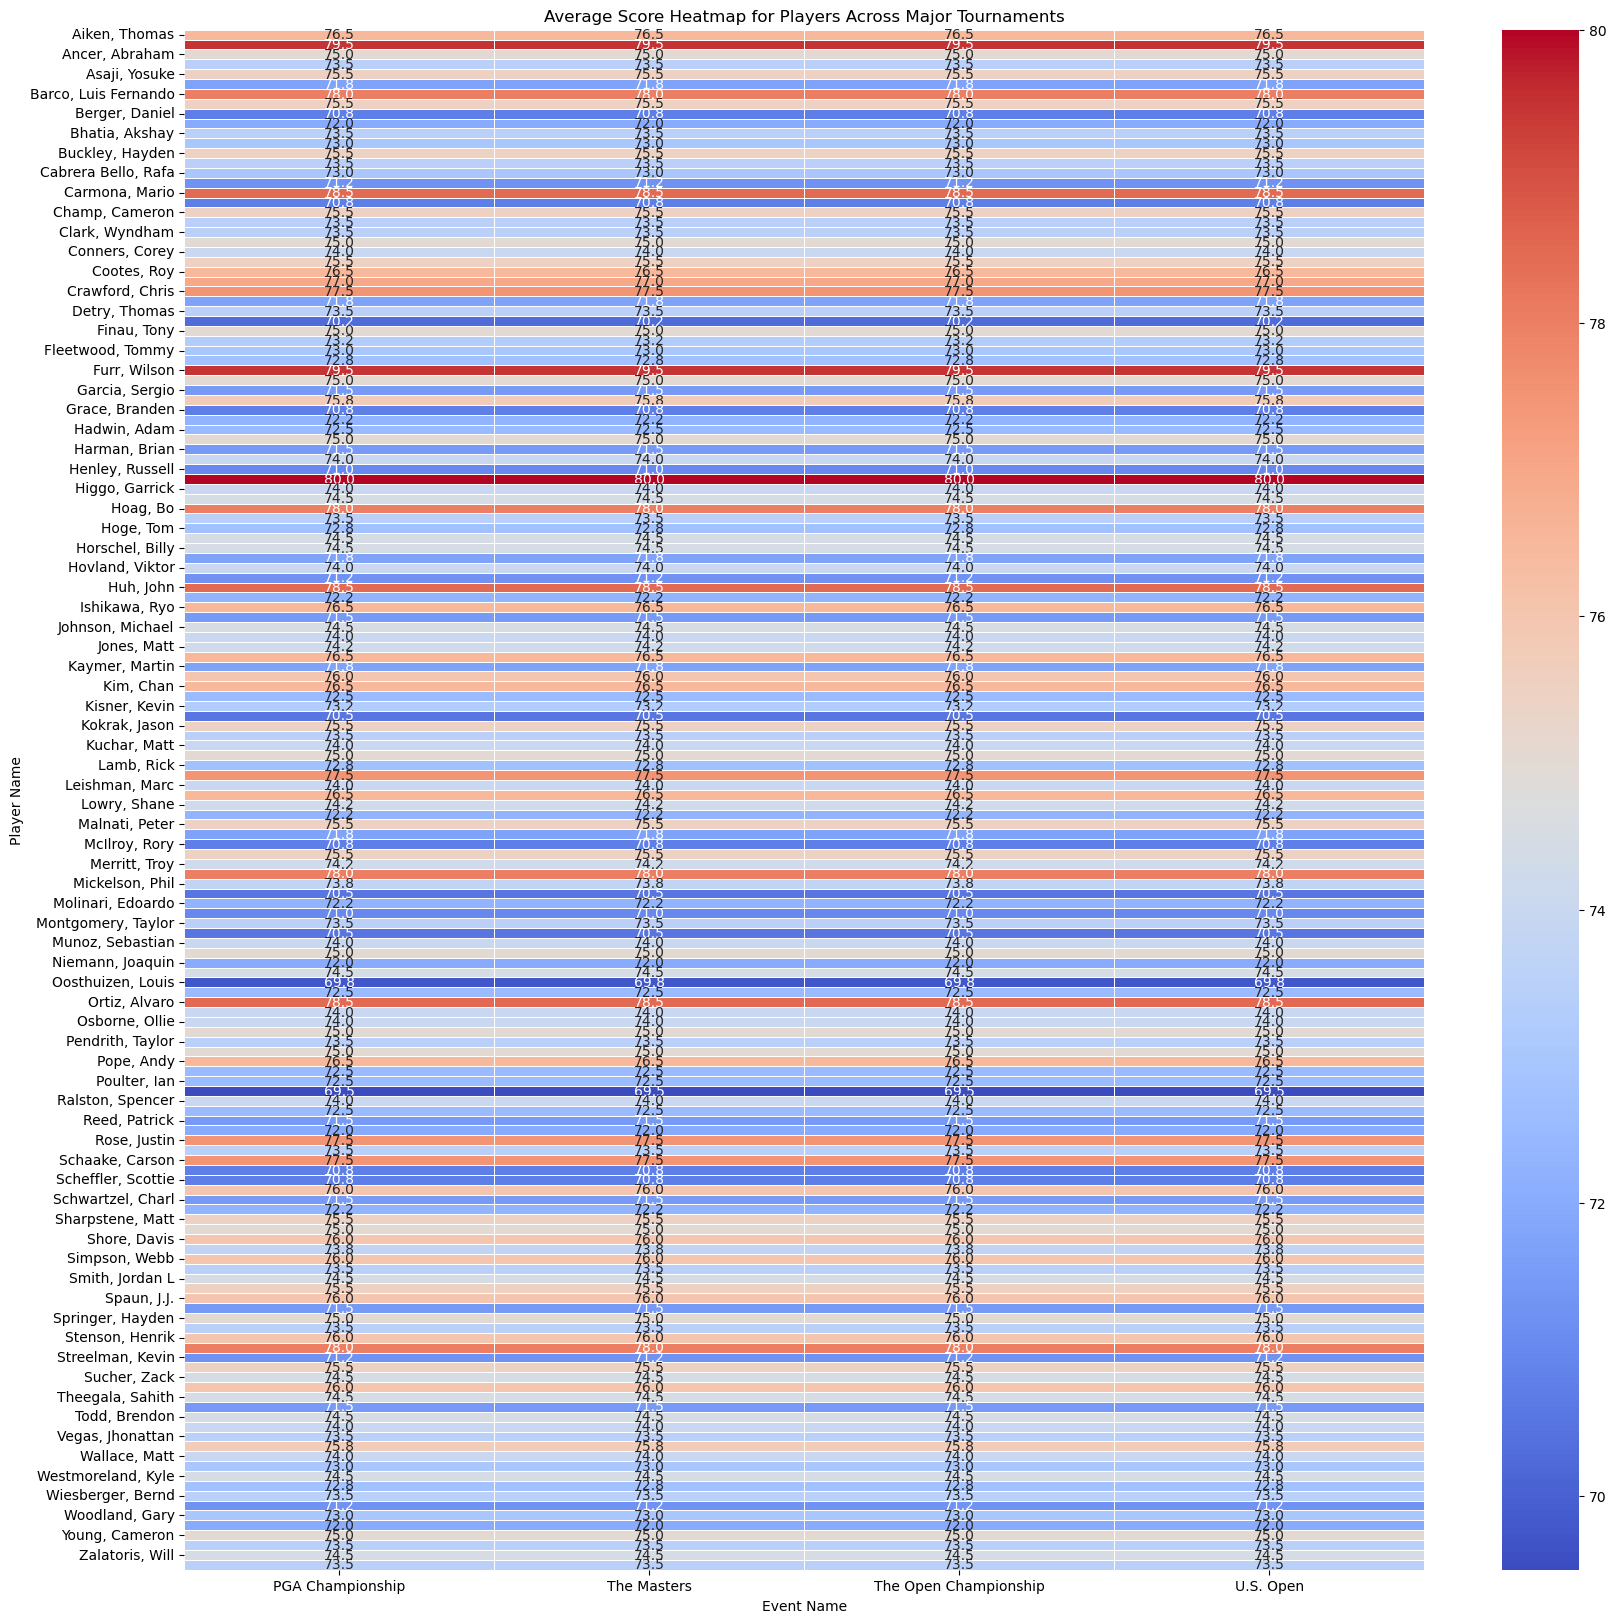

In [149]:
pivot = final_df.pivot_table(values='Score', index='Player Name', columns='Event Name', aggfunc='mean')

# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(20, 20))
sns.heatmap(pivot, annot=True, fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.title('Average Score Heatmap for Players Across Major Tournaments')
plt.show()

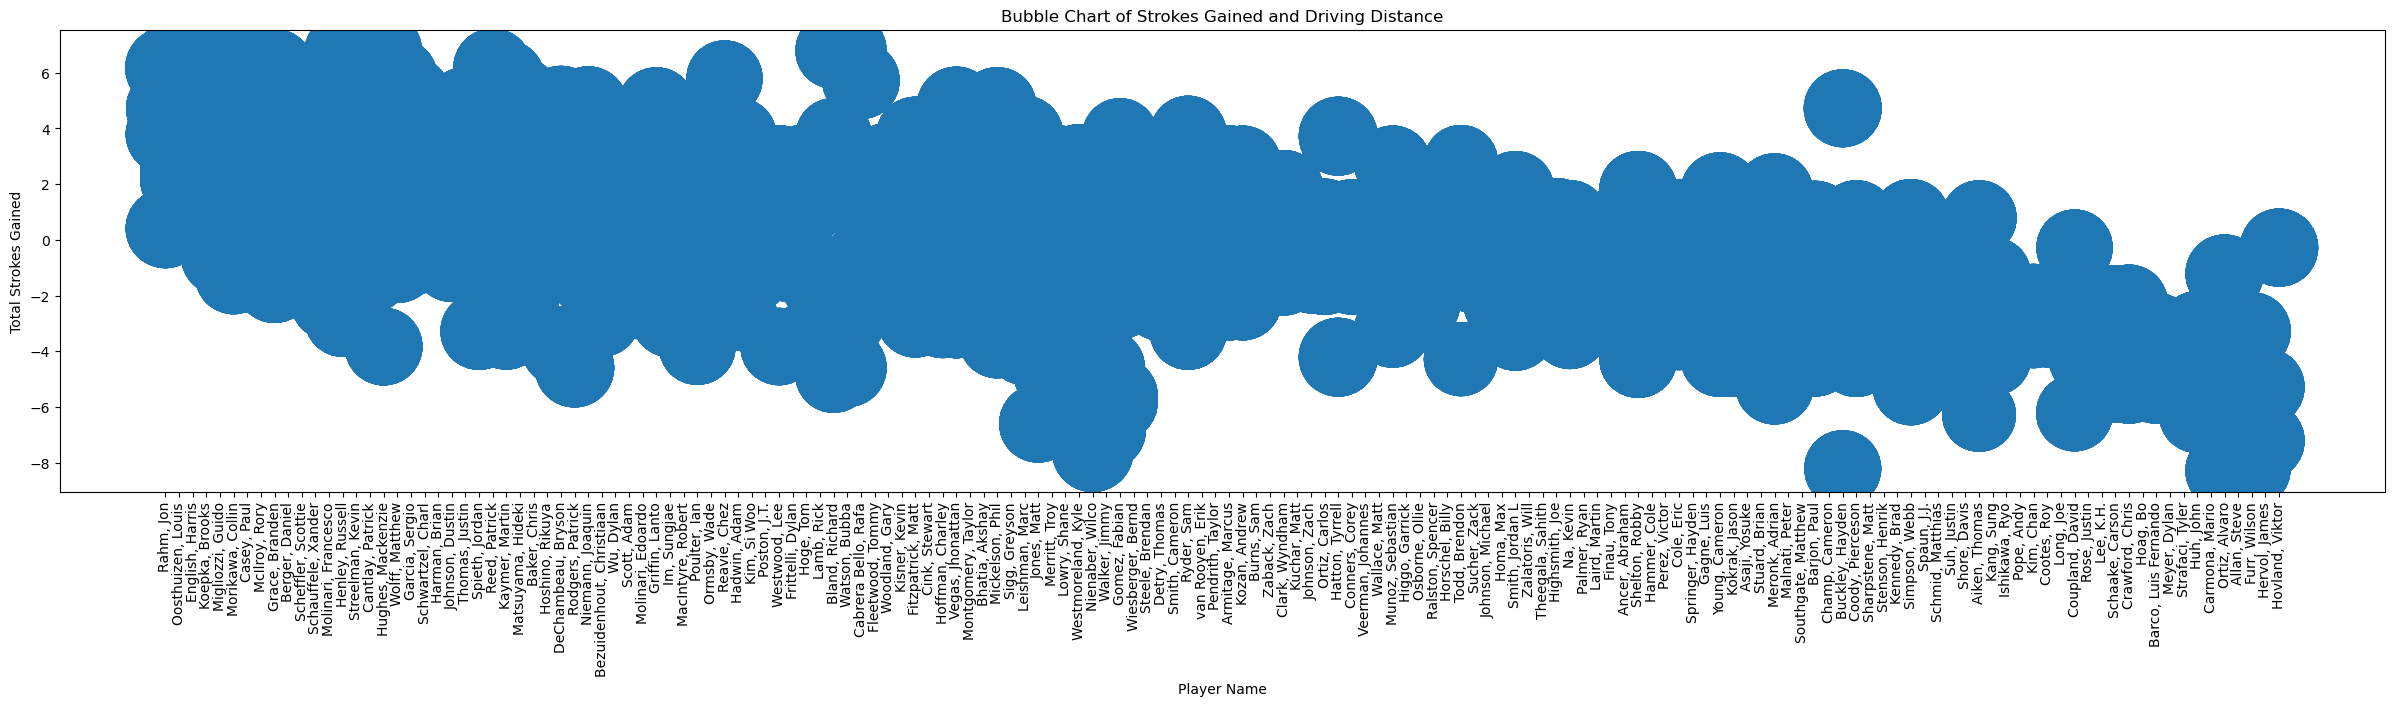

In [159]:
plt.figure(figsize=(30, 6))
plt.scatter(final_df['Player Name'], final_df['SG Total'], s=final_df['Driving Distance']*10, alpha=0.5)
plt.xlabel('Player Name')
plt.ylabel('Total Strokes Gained')
plt.title('Bubble Chart of Strokes Gained and Driving Distance')
plt.xticks(rotation=90)
plt.show()

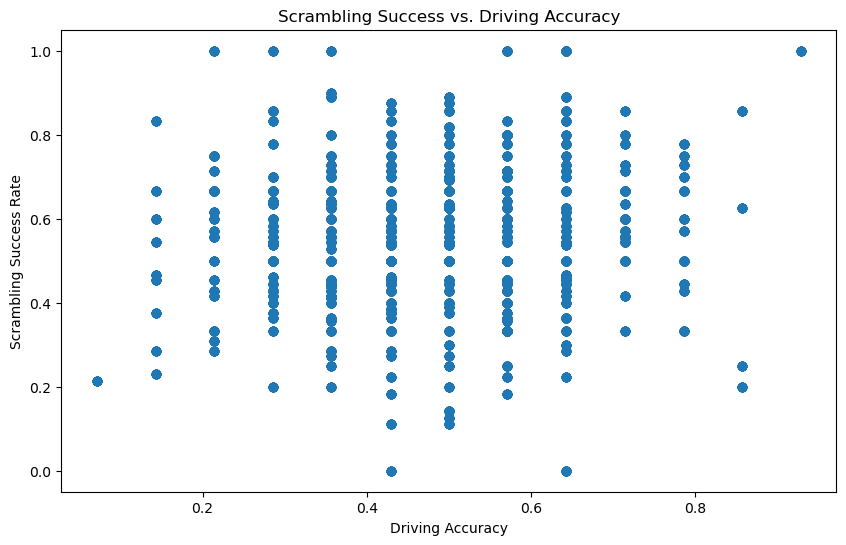

In [156]:
plt.figure(figsize=(10, 6))
plt.scatter(final_df['Driving Accuracy'], final_df['Scrambling'], alpha=0.5)
plt.xlabel('Driving Accuracy')
plt.ylabel('Scrambling Success Rate')
plt.title('Scrambling Success vs. Driving Accuracy')
plt.show()

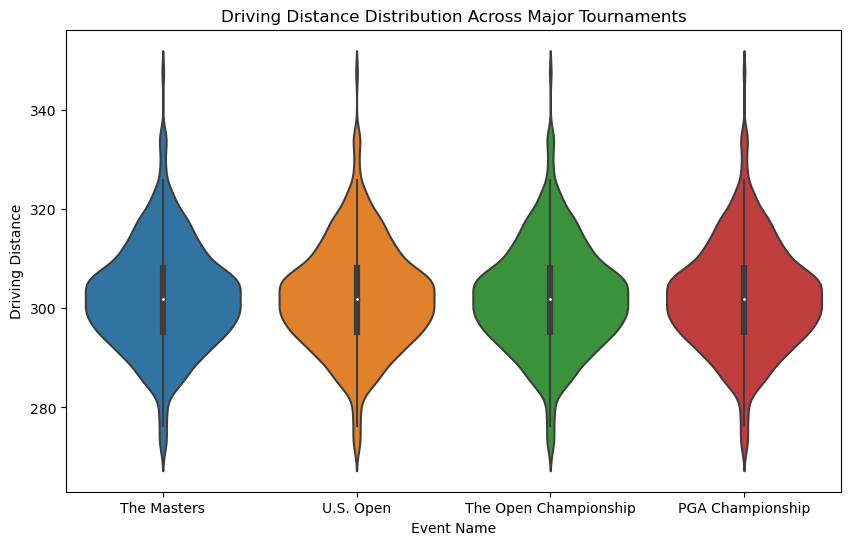

In [163]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=final_df, x='Event Name', y='Driving Distance')
plt.title('Driving Distance Distribution Across Major Tournaments')
plt.show()

In [ ]:
dispersion_df = final_df.groupby('Player Name').agg({'Driving Distance': 'std', 'Driving Accuracy': 'std'}).reset_index()

# Plotting the radial scatter
plt.figure(figsize=(8, 8))
plt.scatter(dispersion_df['Driving Accuracy'], dispersion_df['Driving Distance'], alpha=0.5)
plt.xlabel('Standard Deviation of Driving Accuracy')
plt.ylabel('Standard Deviation of Driving Distance')
plt.title('Approximate Shot Dispersion for Players')
plt.show()

In [137]:
final_df.describe()

Round         Score      SG Total  Driving Distance  \
count  10872.000000  10872.000000  10872.000000      10872.000000   
mean       2.125828     73.450331     -0.000088        302.218322   
std        1.054659      3.080426      3.040229         10.591484   
min        1.000000     67.000000     -8.282000        271.600000   
25%        1.000000     71.000000     -2.213000        295.200000   
50%        2.000000     73.000000      0.169000        301.800000   
75%        3.000000     76.000000      2.169000        308.100000   
max        4.000000     82.000000      6.787000        347.600000   

       Driving Accuracy           GIR    Scrambling  Fairway Proximity  \
count      10872.000000  10872.000000  10872.000000       10872.000000   
mean           0.486594      0.565302      0.556989          33.230258   
std            0.155893      0.126036      0.182200           6.921475   
min            0.071000      0.222000      0.000000          18.780000   
25%            0.357000      0.500000      0.429000          28.174000   
50%            0.500000      0.556000      0.556000          32.599000   
75%            0.571000      0.667000      0.667000          37.407000   
max            0.929000      0.889000      1.000000          56.250000   

       Rough Proximity   Great Shots    Poor Shots  Total Accuracy  
count     10872.000000  10872.000000  10872.000000    10872.000000  
mean         57.025892      3.554084      4.536424        0.279900  
std          19.628685      1.820937      2.132912        0.119541  
min           6.583000      0.000000      0.000000        0.031524  
25%          43.267000      2.000000      3.000000        0.190476  
50%          54.126000      3.000000      4.000000        0.278000  
75%          68.433000      5.000000      6.000000        0.357508  
max         129.960000     10.000000     13.000000        0.722762

<AxesSubplot:>

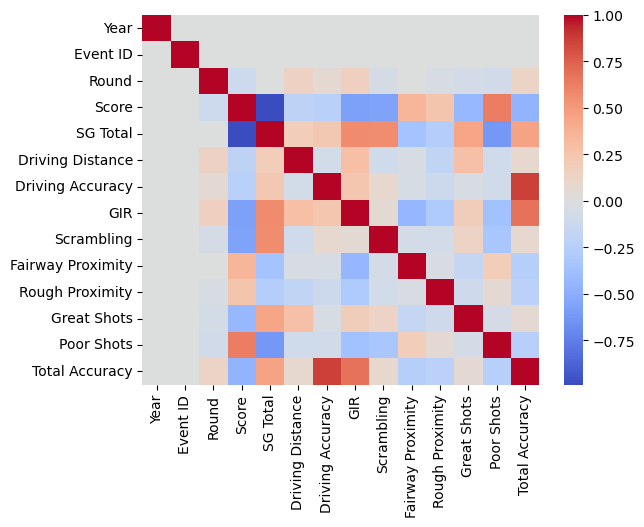

In [170]:
corrs = final_df.corr()
sns.heatmap(corrs, cmap='coolwarm')

In [173]:
fig = px.scatter(final_df, x='Driving Accuracy', y='Scrambling', color='Player Name',
                 hover_data=['Event Name', 'Year', 'Score'])
fig.update_layout(title='Scrambling Success vs. Driving Accuracy (Interactive)')
fig.show()

# Visualizations

In [ ]:
final_df['Total Accuracy'] = final_df['Driving Accuracy'] * final_df['GIR']
final_df

In [ ]:
final_df = final_df.drop(['Year','Event ID', 'Event Name', 'Player Name', 'Tee Time', ], axis=1)
final_df